In [ ]:
assay_index = 0

In [ ]:
import pandas as pd
!gsutil cp gs://chem_dsrc/P0_Toxcast/Data/assay_df/*_df.csv ./

Copying gs://chem_dsrc/P0_Toxcast/Data/assay_df/335_all_assay_df.csv...
Copying gs://chem_dsrc/P0_Toxcast/Data/assay_df/NCCT_TPO_AUR_dn_df.csv...
Copying gs://chem_dsrc/P0_Toxcast/Data/assay_df/NVS_ADME_hCYP1A2_df.csv...
Copying gs://chem_dsrc/P0_Toxcast/Data/assay_df/NVS_ADME_hCYP2B6_df.csv...
/ [4 files][  4.3 MiB/  4.3 MiB]                                                
Operation completed over 4 objects/4.3 MiB.                                      


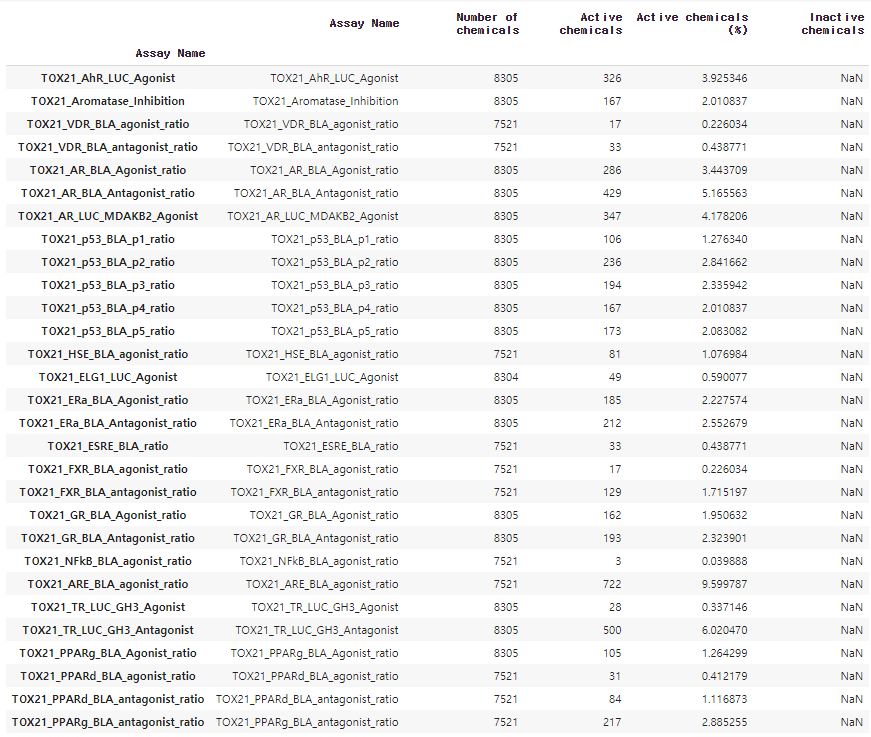

In [ ]:
selected_assay_list = ['NVS_ADME_hCYP1A2' , 'NVS_ADME_hCYP2B6' , 'NCCT_TPO_AUR_dn']

In [ ]:
assay_name = '335_all_assay'
df = pd.read_csv(assay_name+"_df.csv")

In [ ]:
df

Unnamed: 0 TOX21_AhR_LUC_Agonist  ... NVS_NR_hPPARg NVS_NR_hPPARa
0         100-00-5                     N  ...             N           NaN
1        1000-05-1                     N  ...           NaN           NaN
2       10001-13-5                     N  ...           NaN           NaN
3         100-01-6                     N  ...           NaN           NaN
4         100-02-7                     N  ...             N           NaN
...            ...                   ...  ...           ...           ...
9219  NOCAS_903892                   NaN  ...           NaN           NaN
9220  NOCAS_903893                   NaN  ...           NaN           NaN
9221  NOCAS_903894                   NaN  ...           NaN           NaN
9222  NOCAS_903895                   NaN  ...           NaN           NaN
9223  NOCAS_903896                   NaN  ...           NaN           NaN

[9224 rows x 337 columns]

In [ ]:
ss = selected_assay_list[assay_index] # 그룹
a_i = 0 # assay index
ffpp = "maccs"

In [ ]:
# rdkit 2020.03.3 버전 다운로드
!pip install kora -q
import kora.install.rdkit
!pip install pycaret
from pycaret.classification import *
import numpy
import pandas
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys

     |████████████████████████████████| 61kB 2.8MB/s 
     |████████████████████████████████| 61kB 5.6MB/s 
     |████████████████████████████████| 266kB 4.1MB/s 
     |████████████████████████████████| 2.0MB 47.6MB/s 
     |████████████████████████████████| 102kB 8.6MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 
     |████████████████████████████████| 6.8MB 36.6MB/s 
     |████████████████████████████████| 245kB 52.0MB/s 
     |████████████████████████████████| 215kB 48.3MB/s 
     |████████████████████████████████| 81kB 6.5MB/s 
     |████████████████████████████████| 276kB 41.8MB/s 
     |████████████████████████████████| 1.7MB 36.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 14.2MB 326kB/s 
     |████████████████████████████████| 81kB 6.0MB/s 
     |████████████████████████████████| 61kB 5.8MB/s 
     

In [ ]:
from pycaret.utils import enable_colab
enable_colab() #to display interactive visuals.

Colab mode enabled.


In [ ]:
df_ss = df.loc[:,['smiles',ss]]
df_ss = df_ss.dropna()

In [ ]:
assays_ss = df_ss.columns

In [ ]:
assays_ss

Index(['smiles', 'NVS_ADME_hCYP1A2'], dtype='object')

In [ ]:
ss

'NVS_ADME_hCYP1A2'

In [ ]:
#Smiles --> MACCS Keys
assay = ss
df_train  = df_ss[['smiles',ss] ]

smiles_list = []
err_smiles = []# fingerfrint로 변환시 에러 smiles
fps = []
enc_y = []
for index, row in df_train.iterrows():

  if row[-1] == 'N' : 
    target = 0
  else :
    target = 1

  try : 
    mol = Chem.MolFromSmiles(row['smiles'])
    
    if ffpp == 'maccs' :    
        fp = MACCSkeys.GenMACCSKeys(mol)
    elif ffpp == 'morgan' : 
        fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    elif ffpp == 'rdkit' : 
        fp = Chem.RDKFingerprint(mol)
    elif ffpp == 'pattern' : 
        fp = Chem.rdmolops.PatternFingerprint(mol)
    elif ffpp == 'layerd' : 
        fp = Chem.rdmolops.LayeredFingerprint(mol)
    else : 
        print("fingerfrint selection error!")
        
    smiles_list.append(row['smiles'])   
    fps.append(fp)
    enc_y.append(target)
  except : 
    err_smiles.append(row['smiles'])
    pass

np_fps = []
for fp in fps:
  arr = numpy.zeros((1,))
  DataStructs.ConvertToNumpyArray(fp, arr)
  np_fps.append(arr)

np_fps_array = numpy.array(np_fps)

print("변환 에러난 smiles 개수 : ", len(err_smiles), err_smiles)

x_train_res, y_train_res = np_fps_array, np.array(enc_y)
train = pd.DataFrame(data=x_train_res)
train['label'] = y_train_res

변환 에러난 smiles 개수 :  0 []


In [ ]:
d = pd.DataFrame(columns = ['smiles','Type'] )
d['smiles'] = smiles_list
d['Type'] = enc_y

In [ ]:
d

smiles  Type
0                           NC1=CC=C(NC2=CC=CC=C2)C=C1     0
1                                   NC(=O)C(Br)(Br)C#N     0
2    FC1=CC2=C(C=C1N1C(=O)C3=C(CCCC3)C1=O)N(CC#C)C(...     1
3                   CCCCCCCCOC(=O)C1=CC(O)=C(O)C(O)=C1     1
4    C[C@@H](OC1=CC=C(OC2=NC=C(Cl)C=C2F)C=C1)C(=O)O...     1
5            CC(C)(C)C(O)(CCC1=CC=C(Cl)C=C1)CN1C=NC=N1     0
6                     CC#CC1=CC(C)=NC(NC2=CC=CC=C2)=N1     1
7                                           N#CCCCCC#N     0
8       FC(F)C(F)(F)OCC(CN1C=NC=N1)C1=C(Cl)C=C(Cl)C=C1     1
9                  CCCCC(CC)CN1C(=O)C2C3CC(C=C3)C2C1=O     1
10   CCOC(=O)[C@H](C)OC1=CC=C(OC2=NC3=C(O2)C=C(Cl)C...     1
11         O=P(OC1=CC=CC=C1)(OC1=CC=CC=C1)OC1=CC=CC=C1     1
12   COC(=O)CSC1=C(Cl)C=C(F)C(=C1)\N=C1/SC(=O)N2CCC...     0
13   COC(=O)C1=C(CC(C)C)C(C2=NCCS2)=C(N=C1C(F)F)C(F...     1
14               NC1=CC=C2C(=O)C3=C(C=CC=C3)C(=O)C2=C1     1
15                  COC1=CC(=CC=C1N)C1=CC(OC)=C(N)C=C1     0
16      CN(C)S(=O)(=O)N1C(=NC(Cl)=C1C1=CC=C(C)C=C1)C#N     1
17                      OC1=C(CC2=CC=CC=C2)C=C(Cl)C=C1     0
18             O=C(OCCOCCOC(=O)C1=CC=CC=C1)C1=CC=CC=C1     1
19                   CC1=NC(NC2=CC=CC=C2)=NC(=C1)C1CC1     1
20                    CCOC(=O)CC(SP(=S)(OC)OC)C(=O)OCC     1
21            COP(=S)(OC)OC1=CC=C(C(C)=C1)[N+]([O-])=O     1
22     CCOCN1C(=C(C#N)C(Br)=C1C(F)(F)F)C1=CC=C(Cl)C=C1     1
23                                  CCOC(=O)CCC(=O)OCC     0
24                                      CC(C)CCOC(C)=O     0
25                                          CCCCCCCCCC     0
26                       [Mn++].[S-]C(=S)NCCNC([S-])=S     0
27          FC1=CC=C(OC2=CC=NC3=CC(Cl)=CC(Cl)=C23)C=C1     1
28   C(CC1=CC2=C(OCO2)C=C1)N1CCC[C@H](C1)OC(C1=CC=C...     1
29                                [Na+].CN(C)C([S-])=S     0
30   CCOC(=O)C(Cl)CC1=C(Cl)C=C(F)C(=C1)N1N=C(C)N(C(...     0
31   Cl.CC1=C(C[C@H]2CCC3=C(C)C4=C(C=CC=C4)N3C2=O)N...     1
32                   C=CCOC(=O)C1=C(C=CC=C1)C(=O)OCC=C     0
33                  FC1(F)OC2=CC=CC(=C2O1)C1=CNC=C1C#N     1
34               OC1=CC(O)=C(C=C1)C(=O)C1=CC=C(O)C=C1O     1
35                       CCCCOC(=O)C1=C(C=CC=C1)C(O)=O     0
36                    ClC(Cl)(Cl)SN1C(=O)C2CC=CCC2C1=O     0
37      CC(C)C(=O)NC1=CC(=C(C=C1)[N+]([O-])=O)C(F)(F)F     1
38      FC1=CC=C(C=C1)C1(CN2C=NC=N2)OC1C1=C(Cl)C=CC=C1     1
39                            CSC(=O)C1=CC=CC2=C1SN=N2     1
40                             CCCCCCC1=C(O)C=C(O)C=C1     0
41            CCOC(=O)NC1=CC(OC(=O)NC2=CC=CC=C2)=CC=C1     1
42          COC(=O)NC1=CC(OC(=O)NC2=CC=CC(C)=C2)=CC=C1     0
43                            OC(=O)CN(CC(O)=O)CC(O)=O     0
44   C1=C(C=C(C(=C1O)O)O)C(=O)OC2=CC(=CC(=C2O)O)C(=...     1
45       CO\N=C(\C(=O)OC)C1=C(COC2=C(C)C=CC=C2)C=CC=C1     0
46                        N1C2=C(C=CC=C2)N=C1C1=CSC=N1     1
47                Cl.ClC1=CC2=C(CN3CCCCCC3=N2)C(Cl)=C1     1
48                                SC1=NC2=C(S1)C=CC=C2     0
49           COC1=C(NNC(=O)OC(C)C)C=C(C=C1)C1=CC=CC=C1     1
50                          CN(C)C(=O)NC1=CC=C(Cl)C=C1     1
51     [Na+].[O-]C(=O)CC1=C(NC2=C(Cl)C=CC=C2Cl)C=CC=C1     0
52                     IC1=C(C=CC=C1)C(=O)NC1=CC=CC=C1     0
53   CCN(CC)CCNC1=C2C(=O)C3=C(SC2=C(CNC=O)C=C1)C=CC...     0
54         CC1=C(C2=C(C=CC=C2)N1CCCCC(O)=O)C1=CN=CC=C1     0
55                    CCOC(=O)CC(SP(=O)(OC)OC)C(=O)OCC     1
56   O[C@@H]1[C@@H](COC2=CC(O)=CC=C12)N1CCC(O)(CC1)...     0
57   CON(C(=O)OC)C1=C(COC2=NN(C=C2)C2=CC=C(Cl)C=C2)...     0
58           COC(=O)C1=C(Cl)C(Cl)=C(C(=O)OC)C(Cl)=C1Cl     0
59   O[C@H]([C@H](CC1=CC=CC=C1)NC(=O)C1=CC2=CC(Cl)=...     1
60                   ClC1=C(Cl)C(C#N)=C(Cl)C(C#N)=C1Cl     1
61                          CCNC1=NC(NC(C)C)=NC(Cl)=N1     0
62       CC(C)OC1=CC(N2N=C(OC2=O)C(C)(C)C)=C(Cl)C=C1Cl     1
63            Cl.Cl.COC1=CC(=CC=C1N)C1=CC=C(N)C(OC)=C1     1
64          C1=CC=C2C(=C1)C1=CC=CC3=C4C=CC=CC4=CC2=C13     0
65                  C1

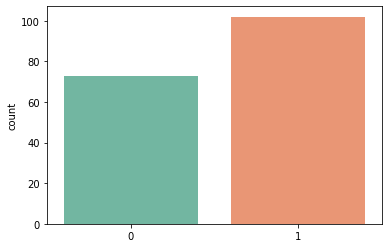

In [ ]:
import seaborn as sns
sns.countplot(enc_y, palette="Set2") #팔레트를 이렇게 바꿀수 있구나.

In [ ]:
#모든 물질에 대한 fingerprint를 string형태로 바꾼다(비교하기위함).
mychems = []
for item in np_fps:
    #print(item)
    item = np.array(item,dtype=int) #왜 굳이 두번? int형으로 추가하려면 이렇게 하면 되는구나....
    s = item.tolist() #넘파이어레이를 리스트로 바꾼다. 
    t = [str(i) for i in s]
    mychems.append(''.join(t))

In [ ]:
i = 0
counter = 0
chemdict = {} #딗셔너리.
listofdups = []
for item in mychems:
    try:
        chemdict[str(item)].append(i)
        #print('dup found')
        for j in range(len(chemdict[str(item)])):
            if (d['Type'][i] != d['Type'][chemdict[str(item)][j]]) :
                listofdups.append(i)
                counter+=1
    except: 
        #print('adding new')
        chemdict[str(item)] = []
        chemdict[str(item)].append(i)
    i+=1
print(str(counter)+' '+str(len(list(set(listofdups)))))
#smote적용하기 전에서 listofdups를 빼면 된다!


1 1


In [ ]:
dups_list = list(set(listofdups))

In [ ]:
dups_list # 0인것만 지우는게 맞나?

[65]

In [ ]:
dups_list_0 = []
for index in dups_list : 
  if train.iloc[index].label == 0 :
    dups_list_0.append(index)

In [ ]:
train = train.drop(dups_list_0)

In [ ]:
train

0    1    2    3    4    5    6    7    8    9   10   11   12   13  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
5    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
9    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
10   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
11   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
12   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
13   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
14   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
15   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
16   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
17   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
18   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
19   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
20   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
21   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
22   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
23   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
24   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
25   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
26   0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
27   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
28   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
29   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
30   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
31   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
32   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
33   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
34   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
35   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
36   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
37   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
38   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
39   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
40   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
41   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
42   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
43   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
44   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
45   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
46   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
47   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
48   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
49   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
50   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
51 

In [ ]:
len(smiles_list)

175

In [ ]:
duplicated_smiles_0_df = pd.DataFrame()
duplicated_smiles_0_df['deleted_duplicate_smiles_0'] = smiles_list
duplicated_smiles_0_df = duplicated_smiles_0_df.iloc[dups_list_0,]
duplicated_smiles_0_df

Empty DataFrame
Columns: [deleted_duplicate_smiles_0]
Index: []

In [ ]:
save_path = 'gs://chem_dsrc/P0_Toxcast/result/3assays_dd/'

In [ ]:
dupdf = ss+"_dup_smiles_df.csv"
duplicated_smiles_0_df.to_csv(dupdf)
duppath = save_path + 'err_smiles/'
!gsutil cp $dupdf $duppath

Copying file://NVS_ADME_hCYP1A2_dup_smiles_df.csv [Content-Type=text/csv]...
/ [1 files][   28.0 B/   28.0 B]                                                
Operation completed over 1 objects/28.0 B.                                       


In [ ]:
import pandas as pd
err_smiles_df = pd.DataFrame(columns = [ss], index = ['err_n','err_smiles'])
err_smiles_df[ss] = [ len(err_smiles), err_smiles]

In [ ]:
ersdf = ss+"_err_smiles_df.csv"
err_smiles_df.to_csv(ersdf)
errpath = save_path + 'err_smiles/'
!gsutil cp $ersdf $errpath $errpath

Copying file://NVS_ADME_hCYP1A2_err_smiles_df.csv [Content-Type=text/csv]...
Omitting prefix "gs://chem_dsrc/P0_Toxcast/result/3assays_dd/err_smiles/". (Did you mean to do cp -r?)

Operation completed over 1 objects/40.0 B.                                       


In [ ]:
err_smiles_df

NVS_ADME_hCYP1A2
err_n                     0
err_smiles               []

In [ ]:
# clf = setup(data = train, target = 'label') 
clf = setup(data = train, target = 'label'
            ,train_size = 0.9
            ,use_gpu =True
            ,session_id=123) 

Description             Value
0                               session_id               123
1                                   Target             label
2                              Target Type            Binary
3                            Label Encoded        0: 0, 1: 1
4                            Original Data        (175, 168)
5                           Missing Values             False
6                         Numeric Features                16
7                     Categorical Features               151
8                         Ordinal Features             False
9                High Cardinality Features             False
10                 High Cardinality Method              None
11                   Transformed Train Set        (157, 154)
12                    Transformed Test Set         (18, 154)
13                      Shuffle Train-Test              True
14                     Stratify Train-Test             False
15                          Fold Generator   StratifiedKFold
16                             Fold Number                10
17                                CPU Jobs                -1
18                                 Use GPU              True
19                          Log Experiment             False
20                         Experiment Name  clf-default-name
21                                     USI              2af2
22                         Imputation Type            simple
23          Iterative Imputation Iteration              None
24                         Numeric Imputer              mean
25      Iterative Imputation Numeric Model              None
26                     Categorical Imputer          constant
27  Iterative Imputation Categorical Model              None
28           Unknown Categoricals Handling    least_frequent
29                               Normalize             False
30                        Normalize Method              None
31                          Transformation             False
32                   Transformation Method              None
33                                     PCA             False
34                              PCA Method              None
35                          PCA Components              None
36                     Ignore Low Variance             False
37                     Combine Rare Levels             False
38                    Rare Level Threshold              None
39                         Numeric Binning             False
40                         Remove Outliers             False
41                      Outliers Threshold              None
42                Remove Multicollinearity             False
43             Multicollinearity Threshold              None
44                              Clustering             False
45                    Clustering Iteration              None
46                     Polynomial Features             False
47                       Polynomial Degree              None
48                    Trignometry Features             False
49                    Polynomial Threshold              None
50                          Group Features             False
51                       Feature Selection             False
52                Feature Selection Method           classic
53            Features Selection Threshold              None
54                     Feature Interaction             False
55                           Feature Ratio             False
56                   Interaction Threshold              None
57                           Fix Imbalance             False
58                    Fix Imbalance Method             SMOTE

# RF - default parameter

In [ ]:
save_path_m = save_path+'/rf/'

In [ ]:
rf = create_model('rf')
rf_df = pull()
rf_df_name = "rf_df_"+ss+".csv"
rf_df.to_csv(rf_df_name)
rf_df_path = save_path_m+ss+"/"
!gsutil cp $rf_df_name $rf_df_path

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.6875  0.5714  0.8889  0.6667  0.7619  0.3333  0.3637
1       0.5000  0.6825  0.5556  0.5556  0.5556 -0.0159 -0.0159
2       0.6250  0.5873  0.5556  0.7143  0.6250  0.2615  0.2698
3       0.5000  0.6190  0.5556  0.5556  0.5556 -0.0159 -0.0159
4       0.6250  0.5952  0.8889  0.6154  0.7273  0.1864  0.2219
5       0.6250  0.5556  0.7778  0.6364  0.7000  0.2131  0.2208
6       0.7500  0.8968  1.0000  0.6923  0.8182  0.4576  0.5447
7       0.4000  0.3519  0.5556  0.5000  0.5263 -0.2857 -0.2887
8       0.7333  0.6204  0.8889  0.7273  0.8000  0.4118  0.4308
9       0.4667  0.5556  0.6667  0.5455  0.6000 -0.1765 -0.1846
Mean    0.5913  0.6036  0.7333  0.6209  0.6670  0.1370  0.1547
SD      0.1126  0.1273  0.1663  0.0751  0.1025  0.2375  0.2577

Copying file://rf_df_NVS_ADME_hCYP1A2.csv [Content-Type=text/csv]...
/ [1 files][  631.0 B/  631.0 B]                                                
Operation completed over 1 objects/631.0 B.                                      


In [ ]:
predict_model(rf)
rf_p_df = pull()
rf_p_df_name = "rf_p_df_"+ss+".csv"
rf_p_df.to_csv(rf_p_df_name)
rf_p_df_path = save_path_m+ss+"/"
!gsutil cp $rf_p_df_name $rf_p_df_path

Model  Accuracy     AUC  ...      F1   Kappa     MCC
0  Random Forest Classifier    0.5556  0.6528  ...  0.6923 -0.0909 -0.0945

[1 rows x 8 columns]

Copying file://rf_p_df_NVS_ADME_hCYP1A2.csv [Content-Type=text/csv]...
/ [1 files][  122.0 B/  122.0 B]                                                
Operation completed over 1 objects/122.0 B.                                      


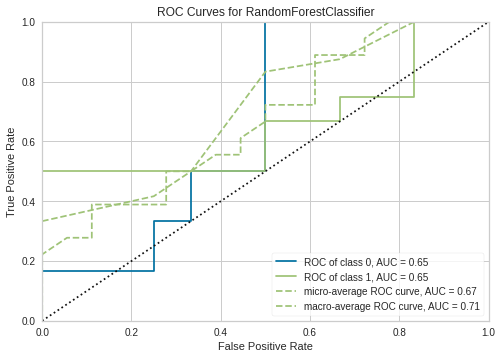

In [ ]:
plot_model(rf, plot = 'auc')

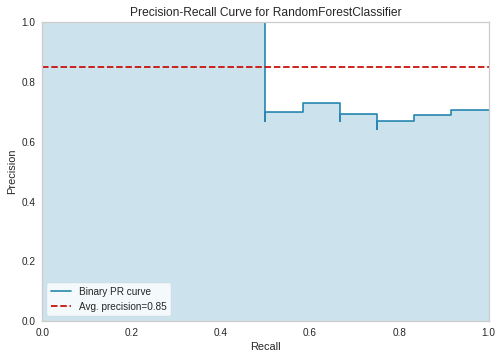

In [ ]:
plot_model(rf, plot = 'pr')

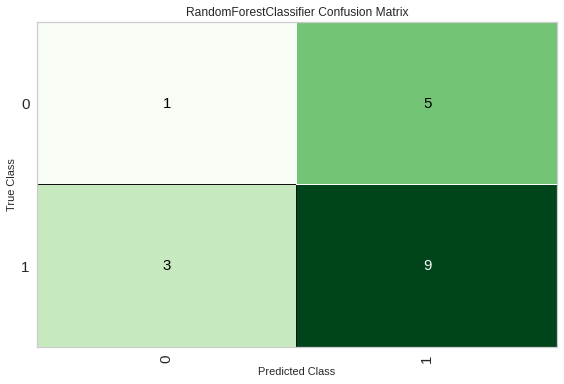

In [ ]:
plot_model(rf, plot = 'confusion_matrix')

In [ ]:
print(rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


# RF - tuned parameter by AUC

In [ ]:
tuned_rf_auc = tune_model(rf, optimize = 'AUC')
tuned_rf_auc_df = pull()
tuned_rf_auc_df_name = "tuned_rf_auc_df_"+ss+".csv"
tuned_rf_auc_df.to_csv(tuned_rf_auc_df_name)
tuned_rf_auc_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_auc_df_name $tuned_rf_auc_df_path

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.6875  0.6667  0.8889  0.6667  0.7619  0.3333  0.3637
1       0.6250  0.6825  0.5556  0.7143  0.6250  0.2615  0.2698
2       0.6250  0.6825  0.5556  0.7143  0.6250  0.2615  0.2698
3       0.5000  0.6190  0.5556  0.5556  0.5556 -0.0159 -0.0159
4       0.6875  0.5079  0.8889  0.6667  0.7619  0.3333  0.3637
5       0.4375  0.4921  0.4444  0.5000  0.4706 -0.1250 -0.1260
6       0.6875  0.7778  0.8889  0.6667  0.7619  0.3333  0.3637
7       0.5333  0.6111  0.7778  0.5833  0.6667 -0.0606 -0.0680
8       0.6000  0.5000  0.7778  0.6364  0.7000  0.1176  0.1231
9       0.5333  0.5926  0.6667  0.6000  0.6316  0.0000  0.0000
Mean    0.5917  0.6132  0.7000  0.6304  0.6560  0.1439  0.1544
SD      0.0830  0.0887  0.1575  0.0662  0.0909  0.1722  0.1844

Copying file://tuned_rf_auc_df_NVS_ADME_hCYP1A2.csv [Content-Type=text/csv]...
/ [1 files][  625.0 B/  625.0 B]                                                
Operation completed over 1 objects/625.0 B.                                      


In [ ]:
predict_model(tuned_rf_auc)
tuned_rf_auc_p_df = pull()
tuned_rf_auc_p_df_name = "tuned_rf_auc_p_df_"+ss+".csv"
tuned_rf_auc_p_df.to_csv(tuned_rf_auc_p_df_name)
tuned_rf_auc_p_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_auc_p_df_name $tuned_rf_auc_p_df_path

Model  Accuracy     AUC  ...      F1   Kappa     MCC
0  Random Forest Classifier    0.6667  0.6389  ...  0.7273  0.3077  0.3162

[1 rows x 8 columns]

Copying file://tuned_rf_auc_p_df_NVS_ADME_hCYP1A2.csv [Content-Type=text/csv]...
/ [1 files][  119.0 B/  119.0 B]                                                
Operation completed over 1 objects/119.0 B.                                      


# RF -tuned parameter by F1

In [ ]:
tuned_rf_f1 = tune_model(rf, optimize = 'F1')
tuned_rf_f1_df = pull()
tuned_rf_f1_df_name = "tuned_rf_f1_df_"+ss+".csv"
tuned_rf_f1_df.to_csv(tuned_rf_f1_df_name)
tuned_rf_f1_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_f1_df_name $tuned_rf_f1_df_path

Accuracy  AUC  Recall   Prec.      F1  Kappa  MCC
0       0.5625  0.5     1.0  0.5625  0.7200    0.0  0.0
1       0.5625  0.5     1.0  0.5625  0.7200    0.0  0.0
2       0.5625  0.5     1.0  0.5625  0.7200    0.0  0.0
3       0.5625  0.5     1.0  0.5625  0.7200    0.0  0.0
4       0.5625  0.5     1.0  0.5625  0.7200    0.0  0.0
5       0.5625  0.5     1.0  0.5625  0.7200    0.0  0.0
6       0.5625  0.5     1.0  0.5625  0.7200    0.0  0.0
7       0.6000  0.5     1.0  0.6000  0.7500    0.0  0.0
8       0.6000  0.5     1.0  0.6000  0.7500    0.0  0.0
9       0.6000  0.5     1.0  0.6000  0.7500    0.0  0.0
Mean    0.5737  0.5     1.0  0.5737  0.7290    0.0  0.0
SD      0.0172  0.0     0.0  0.0172  0.0137    0.0  0.0

Copying file://tuned_rf_f1_df_NVS_ADME_hCYP1A2.csv [Content-Type=text/csv]...
/ [1 files][  473.0 B/  473.0 B]                                                
Operation completed over 1 objects/473.0 B.                                      


In [ ]:
predict_model(tuned_rf_f1)
tuned_rf_f1_p_df = pull()
tuned_rf_f1_p_df_name = "tuned_rf_f1_p_df_"+ss+".csv"
tuned_rf_f1_p_df.to_csv(tuned_rf_f1_p_df_name)
tuned_rf_f1_p_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_f1_p_df_name $tuned_rf_f1_p_df_path

Model  Accuracy  AUC  Recall  Prec.   F1  Kappa  MCC
0  Random Forest Classifier    0.3333  0.5     0.0    0.0  0.0    0.0  0.0

Copying file://tuned_rf_f1_p_df_NVS_ADME_hCYP1A2.csv [Content-Type=text/csv]...
/ [1 files][  104.0 B/  104.0 B]                                                
Operation completed over 1 objects/104.0 B.                                      


# RF -tuned parameter by Kappa

In [ ]:
tuned_rf_kappa = tune_model(rf, optimize = 'Kappa')
tuned_rf_kappa_df = pull()
tuned_rf_kappa_df_name = "tuned_rf_kappa_df_"+ss+".csv"
tuned_rf_kappa_df.to_csv(tuned_rf_kappa_df_name)
tuned_rf_kappa_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_kappa_df_name $tuned_rf_kappa_df_path

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.6875  0.6667  0.8889  0.6667  0.7619  0.3333  0.3637
1       0.6250  0.6825  0.5556  0.7143  0.6250  0.2615  0.2698
2       0.6250  0.6825  0.5556  0.7143  0.6250  0.2615  0.2698
3       0.5000  0.6190  0.5556  0.5556  0.5556 -0.0159 -0.0159
4       0.6875  0.5079  0.8889  0.6667  0.7619  0.3333  0.3637
5       0.4375  0.4921  0.4444  0.5000  0.4706 -0.1250 -0.1260
6       0.6875  0.7778  0.8889  0.6667  0.7619  0.3333  0.3637
7       0.5333  0.6111  0.7778  0.5833  0.6667 -0.0606 -0.0680
8       0.6000  0.5000  0.7778  0.6364  0.7000  0.1176  0.1231
9       0.5333  0.5926  0.6667  0.6000  0.6316  0.0000  0.0000
Mean    0.5917  0.6132  0.7000  0.6304  0.6560  0.1439  0.1544
SD      0.0830  0.0887  0.1575  0.0662  0.0909  0.1722  0.1844

Copying file://tuned_rf_kappa_df_NVS_ADME_hCYP1A2.csv [Content-Type=text/csv]...
/ [1 files][  625.0 B/  625.0 B]                                                
Operation completed over 1 objects/625.0 B.                                      


In [ ]:
predict_model(tuned_rf_kappa)
tuned_rf_kappa_p_df = pull()
tuned_rf_kappa_p_df_name = "tuned_rf_kappa_p_df_"+ss+".csv"
tuned_rf_kappa_p_df.to_csv(tuned_rf_kappa_p_df_name)
tuned_rf_kappa_p_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_kappa_p_df_name $tuned_rf_kappa_p_df_path

Model  Accuracy     AUC  ...      F1   Kappa     MCC
0  Random Forest Classifier    0.6667  0.6389  ...  0.7273  0.3077  0.3162

[1 rows x 8 columns]

Copying file://tuned_rf_kappa_p_df_NVS_ADME_hCYP1A2.csv [Content-Type=text/csv]...
/ [1 files][  119.0 B/  119.0 B]                                                
Operation completed over 1 objects/119.0 B.                                      


# RF -tuned parameter by MCC

In [ ]:
tuned_rf_MCC = tune_model(rf, optimize = 'MCC')
tuned_rf_MCC_df = pull()
tuned_rf_MCC_df_name = "tuned_rf_MCC_df_"+ss+".csv"
tuned_rf_MCC_df.to_csv(tuned_rf_MCC_df_name)
tuned_rf_MCC_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_MCC_df_name $tuned_rf_MCC_df_path

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.5625  0.6190  0.6667  0.6000  0.6316  0.0968  0.0976
1       0.6875  0.6667  0.6667  0.7500  0.7059  0.3750  0.3780
2       0.5000  0.6984  0.3333  0.6000  0.4286  0.0448  0.0510
3       0.5000  0.6349  0.5556  0.5556  0.5556 -0.0159 -0.0159
4       0.6875  0.5238  0.8889  0.6667  0.7619  0.3333  0.3637
5       0.4375  0.4444  0.4444  0.5000  0.4706 -0.1250 -0.1260
6       0.7500  0.6508  1.0000  0.6923  0.8182  0.4576  0.5447
7       0.4667  0.5370  0.6667  0.5455  0.6000 -0.1765 -0.1846
8       0.6000  0.4630  0.6667  0.6667  0.6667  0.1667  0.1667
9       0.6667  0.6667  1.0000  0.6429  0.7826  0.1935  0.3273
Mean    0.5858  0.5905  0.6889  0.6220  0.6422  0.1350  0.1602
SD      0.1029  0.0864  0.2096  0.0720  0.1242  0.2006  0.2263

Copying file://tuned_rf_MCC_df_NVS_ADME_hCYP1A2.csv [Content-Type=text/csv]...
/ [1 files][  620.0 B/  620.0 B]                                                
Operation completed over 1 objects/620.0 B.                                      


In [ ]:
predict_model(tuned_rf_MCC)
tuned_rf_MCC_p_df = pull()
tuned_rf_MCC_p_df_name = "tuned_rf_MCC_p_df_"+ss+".csv"
tuned_rf_MCC_p_df.to_csv(tuned_rf_MCC_p_df_name)
tuned_rf_MCC_p_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_MCC_p_df_name $tuned_rf_MCC_p_df_path

Model  Accuracy     AUC  ...      F1   Kappa     MCC
0  Random Forest Classifier    0.6667  0.6944  ...  0.7273  0.3077  0.3162

[1 rows x 8 columns]

Copying file://tuned_rf_MCC_p_df_NVS_ADME_hCYP1A2.csv [Content-Type=text/csv]...
/ [1 files][  119.0 B/  119.0 B]                                                
Operation completed over 1 objects/119.0 B.                                      


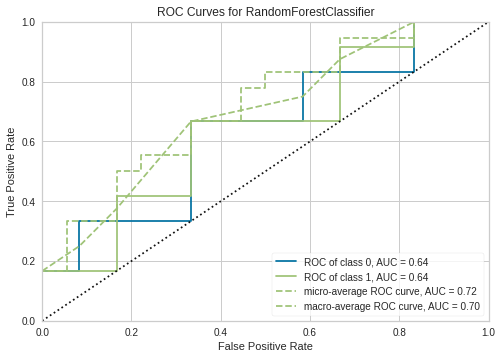

In [ ]:
plot_model(tuned_rf_auc, plot = 'auc')

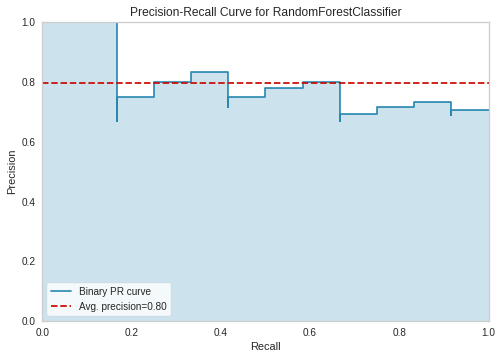

In [ ]:
plot_model(tuned_rf_auc, plot = 'pr')

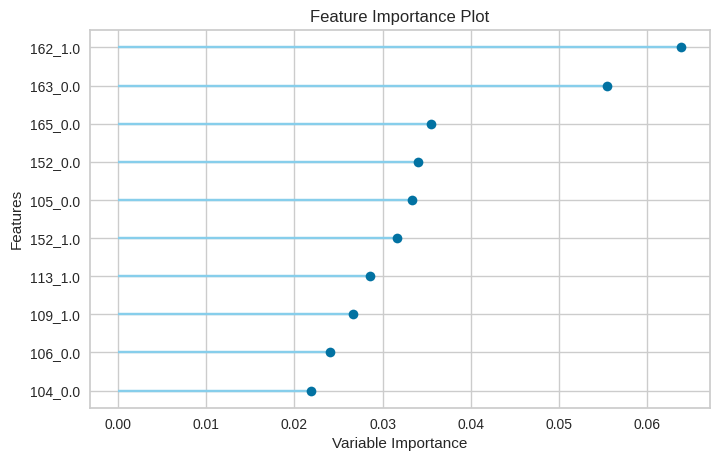

In [ ]:
plot_model(tuned_rf_auc, plot='feature')

In [ ]:
print(tuned_rf_auc)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=6, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=190, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)


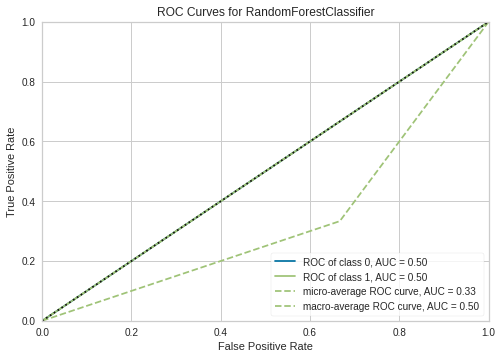

In [ ]:
plot_model(tuned_rf_f1, plot = 'auc')

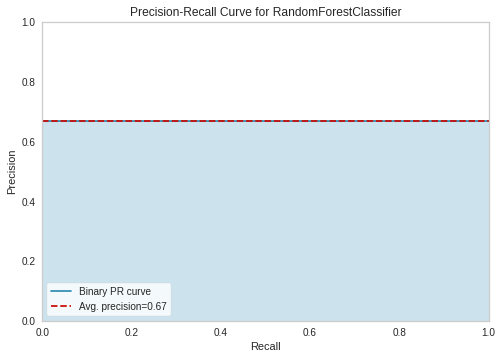

In [ ]:
plot_model(tuned_rf_f1, plot = 'pr')

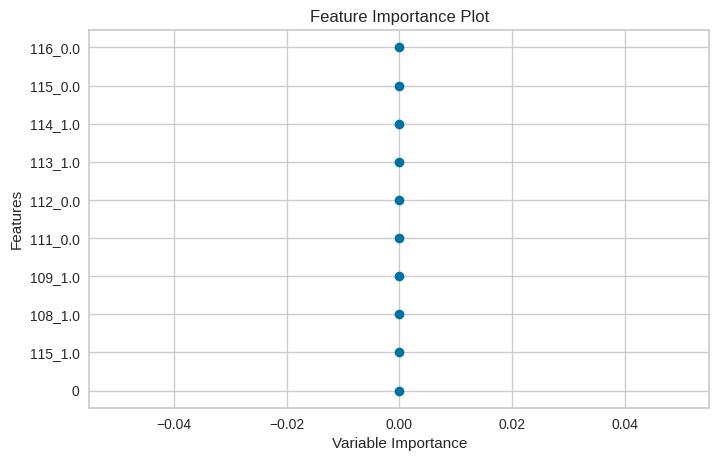

In [ ]:
plot_model(tuned_rf_f1, plot='feature')

In [ ]:
print(tuned_rf_f1)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=2, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.1, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


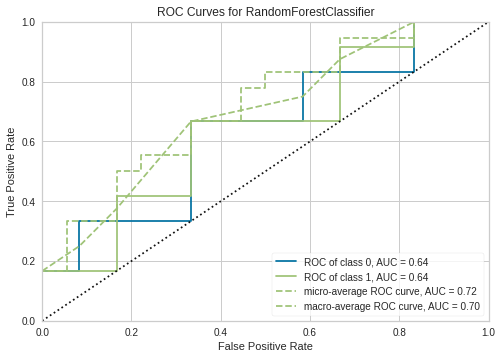

In [ ]:
plot_model(tuned_rf_kappa, plot = 'auc')

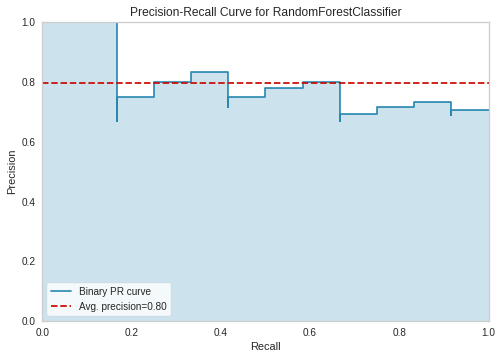

In [ ]:
plot_model(tuned_rf_kappa, plot = 'pr')

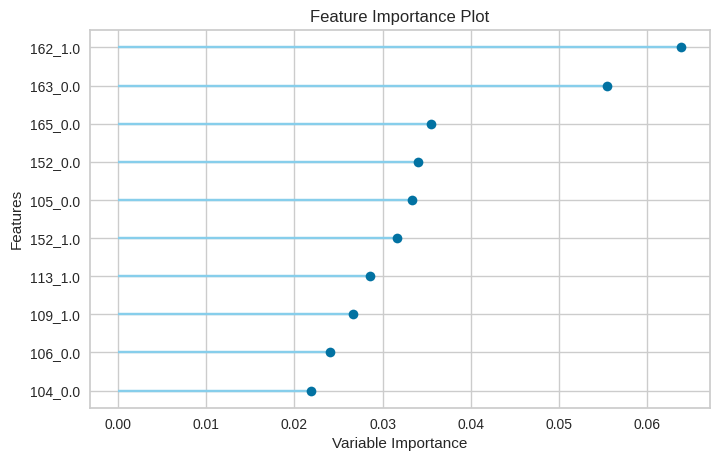

In [ ]:
plot_model(tuned_rf_kappa, plot='feature')

In [ ]:
print(tuned_rf_kappa)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=6, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=190, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)


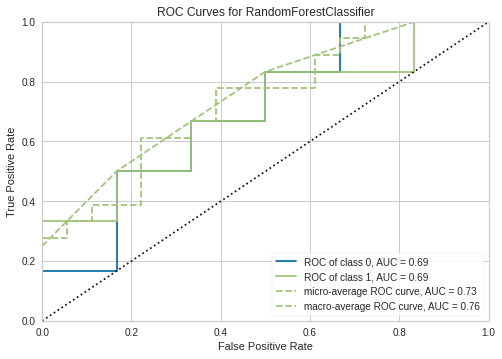

In [ ]:
plot_model(tuned_rf_MCC, plot = 'auc')

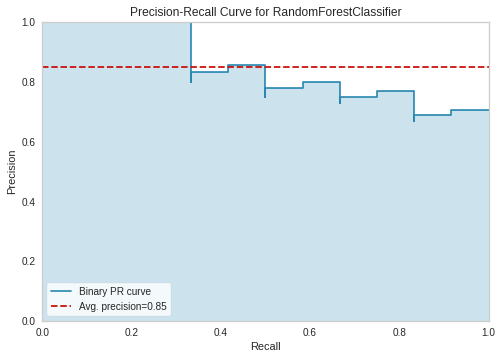

In [ ]:
plot_model(tuned_rf_MCC, plot = 'pr')

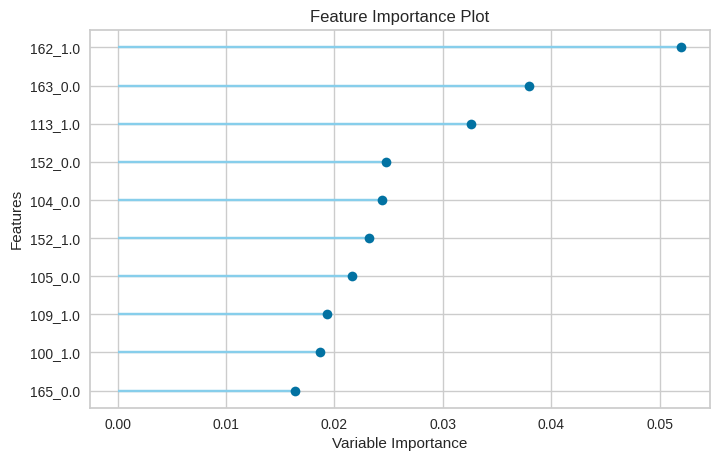

In [ ]:
plot_model(tuned_rf_MCC, plot='feature')

In [ ]:
print(tuned_rf_MCC)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=4, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0002,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=130, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)


# all algorithm compare with validation auc

In [ ]:
best_specific = compare_models (sort = 'AUC', n_select = 6)
allml_df = pull()
allml_df_name = "allml_df_"+ss+".csv"
allml_df.to_csv(allml_df_name)
allml_df_path = save_path+"allml/"+ss+"/"
!gsutil cp $allml_df_name $allml_df_path

Model  Accuracy     AUC  Recall   Prec.  \
rf               Random Forest Classifier    0.5913  0.6036  0.7333  0.6209   
et                 Extra Trees Classifier    0.5462  0.5899  0.6556  0.5907   
lightgbm  Light Gradient Boosting Machine    0.5475  0.5722  0.6889  0.5886   
knn                K Neighbors Classifier    0.5467  0.5583  0.6667  0.6000   
nb                            Naive Bayes    0.5679  0.5471  0.6444  0.6237   
gbc          Gradient Boosting Classifier    0.5275  0.5399  0.6222  0.5792   
qda       Quadratic Discriminant Analysis    0.4575  0.5262  0.0667  0.0857   
lr                    Logistic Regression    0.5108  0.5201  0.6111  0.5575   
dt               Decision Tree Classifier    0.5225  0.5103  0.5889  0.5789   
lda          Linear Discriminant Analysis    0.4517  0.4664  0.4333  0.5300   
ada                  Ada Boost Classifier    0.5088  0.4614  0.6000  0.5611   
svm                   SVM - Linear Kernel    0.4717  0.0000  0.5444  0.5282   
ridge                    Ridge Classifier    0.4775  0.0000  0.5111  0.5433   

              F1   Kappa     MCC  TT (Sec)  
rf        0.6670  0.1370  0.1547     0.999  
et        0.6175  0.0567  0.0680     0.974  
lightgbm  0.6262  0.0442  0.0615     0.051  
knn       0.6236  0.0535  0.0614     0.040  
nb        0.6279  0.1052  0.1099     0.018  
gbc       0.5979  0.0143  0.0109     0.139  
qda       0.0750  0.0508  0.0524     0.038  
lr        0.5779 -0.0140 -0.0111     0.072  
dt        0.5765  0.0176  0.0192     0.018  
lda       0.4669 -0.0925 -0.0928     0.066  
ada       0.5751 -0.0143 -0.0097     0.127  
svm       0.5139 -0.0844 -0.1004     0.017  
ridge     0.5203 -0.0540 -0.0602     0.036

Copying file://allml_df_NVS_ADME_hCYP1A2.csv [Content-Type=text/csv]...
/ [1 files][  1.1 KiB/  1.1 KiB]                                                
Operation completed over 1 objects/1.1 KiB.                                      
